In [108]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.opflow import PauliSumOp

# https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html
from qiskit.opflow.gradients import Gradient #, NaturalGradient, QFI, Hessian

import time
import warnings
warnings.filterwarnings('ignore')

algorithm_globals.random_seed = 42


In [109]:
data = load_iris(as_frame = False)

In [110]:
X_data = data.data
Y_data = data.target

In [111]:
datad = pd.DataFrame(data=X_data, columns=data.feature_names)
datad.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [112]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [113]:
list(data.target_names)

['setosa', 'versicolor', 'virginica']

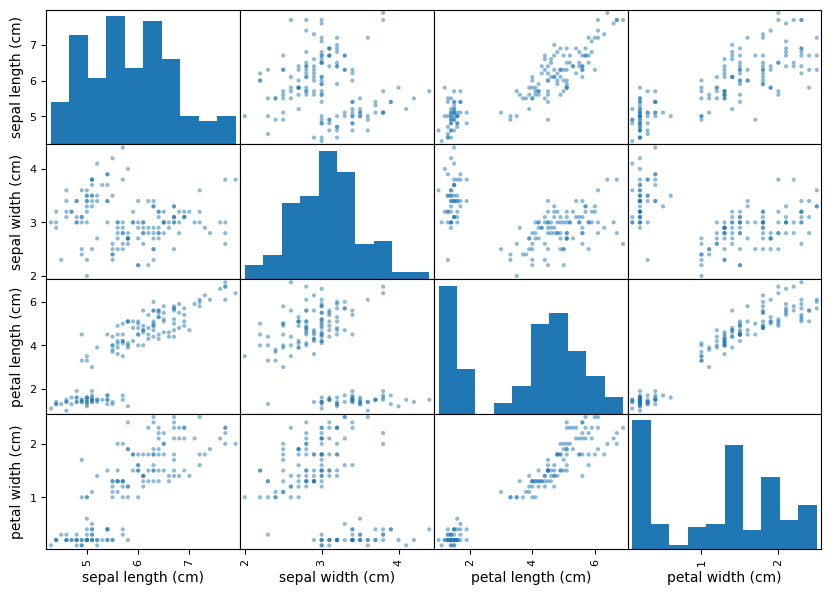

In [114]:
scatter_matrix(datad)
plt.show()

In [115]:
scaler_mm = MinMaxScaler()
X_data_temp = scaler_mm.fit_transform(X_data)
X_data_temp[:10]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

In [116]:
ohe_transformer = OneHotEncoder(sparse = False)
Y_data_temp = ohe_transformer.fit_transform(Y_data.reshape(-1,1))
Y_data_temp[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [117]:
features = X_data_temp.shape[1]
features

4

In [118]:
feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")

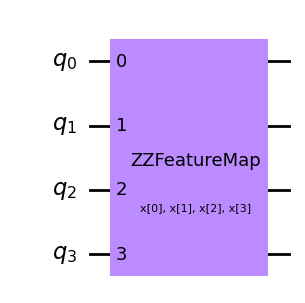

In [119]:
feature_map.draw('mpl')

In [120]:
num_qubits = features
variational_circ = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")

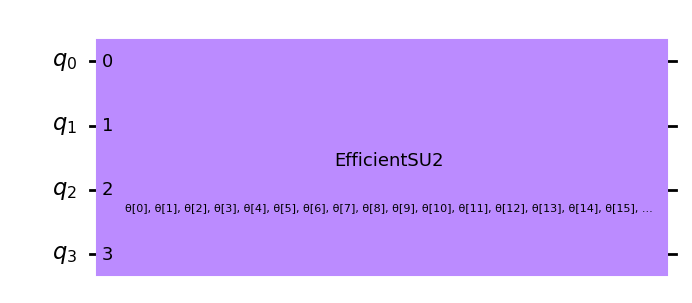

In [121]:
variational_circ.draw('mpl')

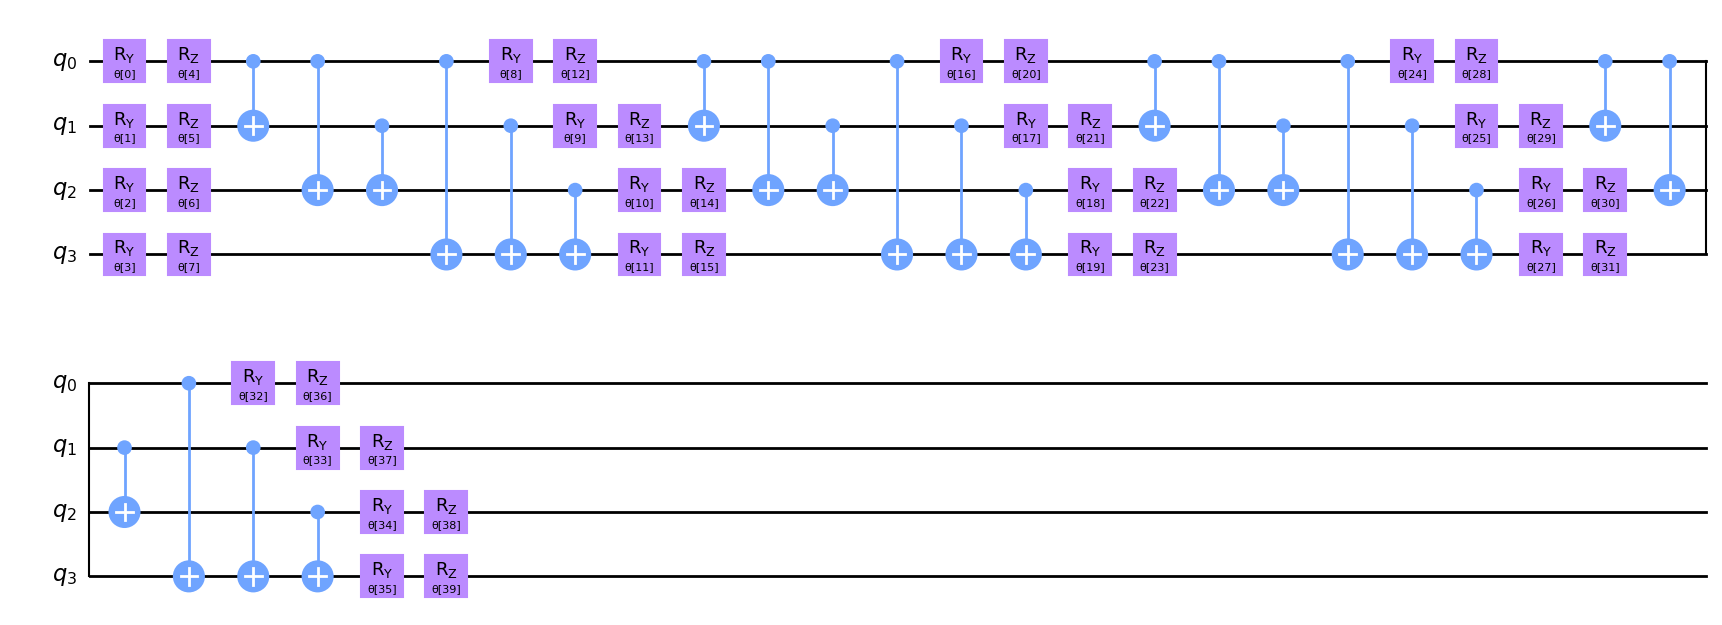

In [122]:
variational_circ.decompose().draw('mpl')

In [123]:
#qiskit azure libraries
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

In [124]:
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/27e69b46-e921-4667-9271-520949917c36/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qunttrial01",
    location = "East US")

In [125]:
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.simulator
- ionq.simulator
- ionq.simulator
- ionq.qpu
- ionq.qpu
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s1-apival
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1sc
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s2-apival
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-2sc
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s1-sim
- quantinuum.sim.h1-1e
- quantinuum.sim.h1-1e
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.sim.h1-2e
- quantinuum.sim.h1-2e
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1
- quantinuum.qpu.h1-1
- quantinuum.qpu.h1-1
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2
- quantinuum.qpu.h1-2
- quantinuum.qpu.h1-2
- rigetti.sim.qvm
- rigetti.qpu.aspen-m-3
- microsoft.estimator


In [126]:
backend = provider.get_backend("ionq.simulator")
print(backend)

ionq.simulator


In [127]:
# specify the observable
observable = PauliSumOp.from_list([("ZZ" * num_qubits, 1)])
print(observable)

1.0 * ZZZZZZZZ


In [128]:
quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)

In [129]:
two_layers = False

if two_layers:
    
    qnn_architecture = TwoLayerQNN(
        num_qubits, 
        feature_map=feature_map, 
        ansatz=variational_circ, 
        observable=observable, 
        quantum_instance=quantum_instance
    )

else:
    
    num_inputs = features

    # construct quantum circuit
    qc = QuantumCircuit(num_inputs)
    qc.append(feature_map, range(num_inputs))
    qc.append(variational_circ, range(num_inputs))
    qc.decompose().draw(output="mpl")

    # parity maps bitstrings to 0 or 1
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    output_shape = len(np.unique(Y_data))  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

    # construct QNN
    qnn_architecture = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=variational_circ.parameters,
        interpret=parity,
        output_shape=output_shape,
        gradient=Gradient(),
        quantum_instance=quantum_instance,
    )


In [130]:
# define (random) input and weights
input3 = algorithm_globals.random.random(qnn_architecture.num_inputs)
weights3 = algorithm_globals.random.random(qnn_architecture.num_weights)

In [131]:
# QNN forward pass
qnn_architecture.forward(input3, weights3)

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored


.............

array([[0.390625, 0.609375, 0.      ]])

In [132]:
# QNN backward pass
qnn_architecture.backward(input3, weights3)

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

.................................................................................

(None,
 array([[[-0.02636719, -0.02880859,  0.04785156, -0.01806641,
           0.04931641,  0.11035156, -0.04931641, -0.08691406,
          -0.00195313,  0.07763672, -0.00634766, -0.08300781,
           0.01220703, -0.00585937, -0.01220703,  0.02490234,
           0.00927734, -0.06689453,  0.00927734,  0.04199219,
          -0.02246094, -0.00097656, -0.04882813, -0.03857422,
          -0.00146484, -0.02636719, -0.1015625 , -0.05664063,
          -0.00927734, -0.02539063,  0.00097656, -0.04833984,
           0.18115234, -0.13085938, -0.04052734,  0.02734375,
           0.01367188, -0.00097656, -0.00341797,  0.00097656],
         [ 0.02636719,  0.02880859, -0.04785156,  0.01806641,
          -0.04931641, -0.11035156,  0.04931641,  0.08691406,
           0.00195312, -0.07763672,  0.00634766,  0.08300781,
          -0.01220703,  0.00585937,  0.01220703, -0.02490234,
          -0.00927734,  0.06689453, -0.00927734, -0.04199219,
           0.02246094,  0.00097656,  0.04882812,  0.03857422,


In [133]:
X_data.shape

(150, 4)

In [134]:
Y_data.shape

(150,)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_data_temp, Y_data_temp, test_size=0.2, random_state=algorithm_globals.random_seed)

In [136]:
X_train.shape

(120, 4)

In [137]:
y_train.shape

(120, 3)

In [138]:
optimizer = COBYLA(maxiter =10 , tol = 0.001)

In [139]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [140]:
qnnc = NeuralNetworkClassifier(qnn_architecture, optimizer=optimizer, callback=callback_graph)


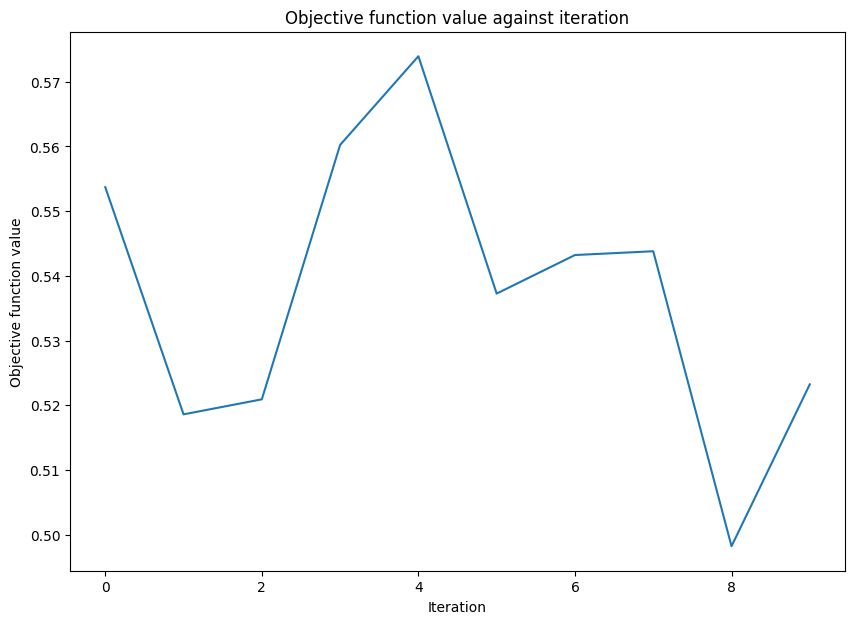

Training time: 4231 seconds


In [141]:
objective_func_vals = []
y_train_fit = y_train.T[0]
start = time.time()
qnnc.fit(X_train, y_train_fit)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [142]:
# plt.rcParams['figure.figsize'] = [10, 7]

# objective_func_vals = []

# y_train_fit = y_train.T[0]

# qnnc.fit(X_train, y_train_fit)

# elapsed = time.time() - start

# print("Time elapsed: ", elapsed)

# plt.show()

In [143]:
print("Train score: {:.2f} %".format(qnnc.score(X_train, y_train_fit)*100))

y_test_score = np.array(y_test).T[0]

print("Test score: {:.2f} %".format(qnnc.score(X_test, y_test_score)*100))

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

...................................................................................................................................Train score: 53.33 %


seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

..........................................Test score: 63.33 %
